In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
os.getcwd()

'/home/keerthanaprasad/RajithaKV/CODES_TESTED'

In [90]:
import numpy as np
import os
from tqdm import tqdm
import cv2
import glob
import datetime
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%reload_ext tensorboard
import skimage.io as io
import skimage.transform as trans
from skimage import img_as_ubyte
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import Model, Input
from keras import backend as K
from tensorflow.keras.utils import plot_model

## Loss Function and Metrics

In [91]:
# #LOSS FUNCTIONS
# def jacard_coef_loss(y_true, y_pred):
#     return -jacard_coef(y_true, y_pred)  # -1 multiplied as we want to minimize this value as loss function

# def dice_coef_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)

# #METRICS
# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# def dice_coef(y_true,y_pred):
#     inters = K.sum(K.abs(y_true * y_pred), axis=-1)
#     dice = (2. * inters + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1)
#     return dice

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # def auc(y_true, y_pred):
# #     auc = tf.metrics.auc(y_true, y_pred)[1]
# #     K.get_session().run(tf.local_variables_initializer())
# #     return auc

# miou = tf.keras.metrics.MeanIoU(num_classes=2)

# #Focal Loss
# def binary_focal_loss(y_true, y_pred):
#     gamma = 2.0
#     alpha = 0.25
#     epsilon = K.epsilon()
#     y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
#     p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
#     alpha_factor = K.ones_like(y_true)*alpha
#     alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
#     cross_entropy = -K.log(p_t)
#     weight = alpha_t * K.pow((1-p_t), gamma)
#     loss = weight * cross_entropy
#     focal_loss = K.sum(loss, axis=1)
#     return focal_loss

In [92]:
#METRICS
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true,y_pred):
    inters = K.sum(K.abs(y_true * y_pred), axis=-1)
    dice = (2. * inters + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1)
    return dice

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

miou = tf.keras.metrics.MeanIoU(num_classes=2)

def specificity(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [93]:
#def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
     #y_pred = y_pred.flatten()
     #y_true = y_true.flatten()
     #current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
    # intersection = np.diag(current)
    # ground_truth_set = current.sum(axis=1)
     #predicted_set = current.sum(axis=0)
     #union = ground_truth_set + predicted_set - intersection
   #  IoU = intersection / union.astype(np.float32)
    # return np.mean(IoU)

In [94]:
#LOSS FUNCTIONS

#Jacquard Loss
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 multiplied as we want to minimize this value as loss function

#Dice Loss
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Binary Cross Entropy
binary_ce = tf.keras.losses.BinaryCrossentropy()

#Weighted Binary Cross Entropy
def weighted_bce(y_true, y_pred):
    num_pred = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) + K.sum(y_true)
    zero_weight =  K.sum(y_true)/ num_pred +  K.epsilon() 
    one_weight = K.sum(K.cast(y_pred < 0.5, y_true.dtype)) / num_pred +  K.epsilon()
    weights =  (1.0 - y_true) * zero_weight +  y_true * one_weight 
    bin_crossentropy = K.binary_crossentropy(y_true, y_pred)
    weighted_bin_crossentropy = weights * bin_crossentropy 
    return K.mean(weighted_bin_crossentropy)

#Focal Loss
def binary_focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    p_t = tf.where(K.equal(y_true, 1), y_pred, 1-y_pred)
    alpha_factor = K.ones_like(y_true)*alpha
    alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1-alpha_factor)
    cross_entropy = -K.log(p_t)
    weight = alpha_t * K.pow((1-p_t), gamma)
    loss = weight * cross_entropy
    focal_loss = K.sum(loss, axis=1)
    return focal_loss

#Tversky Loss
def binary_tversky_loss(y_true, y_pred, beta=0.7, smooth=1.0):
    axis_to_reduce = range(1, K.ndim(y_pred)) 
    numerator = K.sum(y_true * y_pred, axis=axis_to_reduce) 
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  
    denominator = K.sum(denominator, axis=axis_to_reduce)
    tversky_coeff = (numerator + smooth) / (denominator + smooth)  
    return 1-tversky_coeff

# def dice_loss(y_true, y_pred, ,beta = 0.5, smooth = 1.0): #Same as Tversky Loss but with Beta = 0.5
#     axis_to_reduce = range(1, K.ndim(y_pred)) 
#     numerator = K.sum(y_true * y_pred, axis=axis_to_reduce)  
#     denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)  
#     denominator = K.sum(denominator, axis=axis_to_reduce)
#     tversky_coeff = (numerator + smooth) / (denominator + smooth)  
#     return 1-tversky_coeff

#Focal Tversky Loss
def focal_tversky(y_true, y_pred):
    epsilon = 1e-5
    smooth = 1.
    alpha = 0.7
    gamma = 0.75
    
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    tversky = (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    return K.pow((1-tversky), gamma)

#Combo Loss
def combo_loss(y_true, y_pred, smooth=1):
    e = K.epsilon()
    if y_pred.shape[-1] <= 1:
        ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
        CE_RATIO = 0.5 # weighted contribution of modified CE loss compared to Dice loss
        y_pred = tf.keras.activations.sigmoid(y_pred)
    elif y_pred.shape[-1] >= 2:
        ALPHA = 0.3    # < 0.5 penalises FP more, > 0.5 penalises FN more
        CE_RATIO = 0.7 # weighted contribution of modified CE loss compared to Dice loss
        y_pred = tf.keras.activations.softmax(y_pred, axis=-1)
        y_true = K.squeeze(y_true, 3)
        y_true = tf.cast(y_true, "int32")
        y_true = tf.one_hot(y_true, num_class, axis=-1)
 
 # cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
 
    targets = K.flatten(y_true)
    inputs = K.flatten(y_pred)
 
    intersection = K.sum(targets * inputs)
    dice = (2. * intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    inputs = K.clip(inputs, e, 1.0 - e)
    out = - (ALPHA * ((targets * K.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * K.log(1.0 - inputs))))
    weighted_ce = K.mean(out, axis=-1)
    combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)

    return combo

## UNET Model

In [95]:
def unet(pretrained_weights = None,input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 =tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 =tf.keras.layers.BatchNormalization()(conv1)
    drop1 = tf.keras.layers.Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 =tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 =tf.keras.layers.BatchNormalization()(conv2)
    drop2 = tf.keras.layers.Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 =tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 =tf.keras.layers.BatchNormalization()(conv3)
    drop3 = tf.keras.layers.Dropout(0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 =tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 =tf.keras.layers.BatchNormalization()(conv4)
    drop4 = tf.keras.layers.Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 =tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 =tf.keras.layers.BatchNormalization()(conv5)
    drop5 = tf.keras.layers.Dropout(0.3)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 =tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 =tf.keras.layers.BatchNormalization()(conv6)
    drop6 = tf.keras.layers.Dropout(0.2)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 =tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 =tf.keras.layers.BatchNormalization()(conv7)
    drop7 = tf.keras.layers.Dropout(0.2)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 =tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 =tf.keras.layers.BatchNormalization()(conv8)
    drop8 = tf.keras.layers.Dropout(0.1)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 =tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 =tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 =tf.keras.layers.BatchNormalization()(conv9)
    drop9 = tf.keras.layers.Dropout(0.1)(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(drop9)

    model = Model(inputs = inputs, outputs = conv10)
    
    adam=tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

    model.compile(optimizer = adam, loss = [binary_ce], metrics = [jacard_coef, f1_m, precision_m, recall_m, dice_coef, 'accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
    plot_model(model, to_file = '/content/drive/MyDrive/UNET/Unetmodel.png')

## Load Images

In [8]:
train_ids

NameError: name 'train_ids' is not defined

In [96]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_256/Training Set/'
TEST_PATH = '/home/keerthanaprasad/RajithaKV/Data_256_Unet/Data_256/Test Set/'

train_ids = os.listdir(TRAIN_PATH + 'original/')
test_ids = os.listdir(TEST_PATH + 'original/')

In [97]:
# trial = glob.glob(TRAIN_PATH + '/original/*')
# trial[2]

In [98]:
print('Resizing training images and masks')
X_train = []
Y_train = []


#os.chdir('/content/drive/MyDrive/Data')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
   img = imread(TRAIN_PATH + '/original/' + id_)
   X_train.append(img)
   mask = imread(TRAIN_PATH + '/Mask/' + id_ )
   Y_train.append((mask/ 255).reshape(256, 256, 1))

  4%|▍         | 48/1211 [00:00<00:02, 473.87it/s]

Resizing training images and masks


100%|██████████| 1211/1211 [00:02<00:00, 488.95it/s]


In [99]:
print('Resizing test images and masks')

X_test = []
Y_test = []


#os.chdir('/content/drive/MyDrive/Data')       

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  img1 = imread(TEST_PATH + '/original/' + id_ )
  X_test.append(img1)
  mask1 = imread(TEST_PATH  + '/Mask/' + id_ )
  Y_test.append((mask1/ 255).reshape(256, 256, 1))
        
X_train = np.array(X_train)/255
Y_train = np.array(Y_train)
X_test = np.array(X_test)/255
Y_test = np.array(Y_test)

 14%|█▍        | 43/303 [00:00<00:00, 429.13it/s]

Resizing test images and masks


100%|██████████| 303/303 [00:00<00:00, 436.52it/s]


In [100]:
Y_train[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [101]:
Y_train  = Y_train[:,:,:,0]
Y_test  = Y_test[:,:,:,0]

In [102]:
Y_train[1]

array([[0.00784314, 0.02352941, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02352941, ..., 0.        , 0.        ,
        0.        ],
       [0.04705882, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [103]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (1211, 256, 256, 3)
Y_train = (1211, 256, 256)
X_test  = (303, 256, 256, 3)
Y_test  = (303, 256, 256)


In [104]:
Y_train[0].dtype

dtype('float64')

In [105]:
def plotImages(images_arr, num_plots = 5):
    fig, axes = plt.subplots(1, num_plots, figsize=(30, 30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

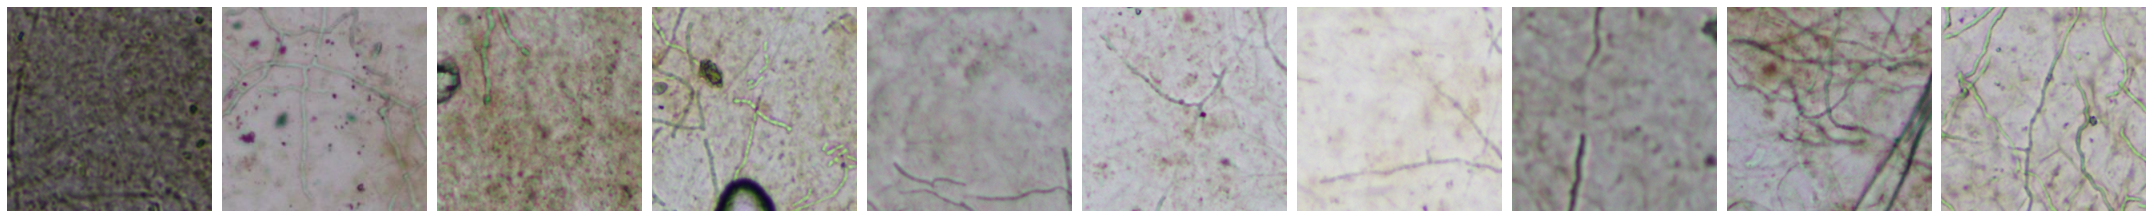

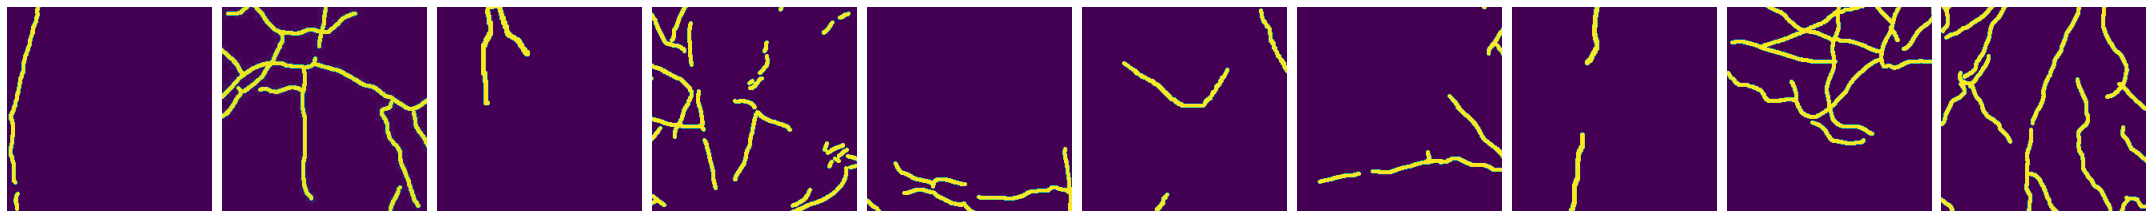

In [106]:

# plot images
plotImages(X_train,10)
plotImages(Y_train,10)

# ------------------------------------------------------------------

In [107]:
log_dir = "logsIOUs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpointer = tf.keras.callbacks.ModelCheckpoint('trial1.h5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(patience = 10, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose = 1, min_delta=0.001, factor = 0.1, patience =2, mode='min', min_lre =  0.00001)

callbacks = [
              checkpointer,
               earlystopper
              , tensorboard, reduce_LR
            ]
##############
model = unet()
##############
history1  = model.fit(X_train, Y_train
                    , batch_size=16
                    , epochs=200
                    , validation_split=0.3
                    , shuffle=True
                    # , validation_data=(X_val, Y_val)
                    # , use_multiprocessing=True
                    , verbose = 1
                    , callbacks=callbacks
                   )

Epoch 1/200
53/53 [==============================] - ETA: 0s - loss: 0.6466 - jacard_coef: 0.0791 - f1_m: 0.2984 - precision_m: 0.1930 - recall_m: 0.6840 - dice_coef: 0.2223 - accuracy: 0.7954
Epoch 00001: val_loss improved from inf to 0.98715, saving model to trial1.h5
53/53 [==============================] - 36s 681ms/step - loss: 0.6466 - jacard_coef: 0.0791 - f1_m: 0.2984 - precision_m: 0.1930 - recall_m: 0.6840 - dice_coef: 0.2223 - accuracy: 0.7954 - val_loss: 0.9871 - val_jacard_coef: 0.0011 - val_f1_m: 8.9027e-04 - val_precision_m: 0.0493 - val_recall_m: 4.4941e-04 - val_dice_coef: 0.2766 - val_accuracy: 0.9320
Epoch 2/200
53/53 [==============================] - ETA: 0s - loss: 0.5677 - jacard_coef: 0.0865 - f1_m: 0.4281 - precision_m: 0.3412 - recall_m: 0.6080 - dice_coef: 0.2481 - accuracy: 0.8942
Epoch 00002: val_loss improved from 0.98715 to 0.52950, saving model to trial1.h5
53/53 [==============================] - 35s 661ms/step - loss: 0.5677 - jacard_coef: 0.0865 - f1_

In [108]:
#Saving Model
model.save('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unet_trial.h5')

In [109]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history1.history) 
hist_csv_file = 'unet_trial.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

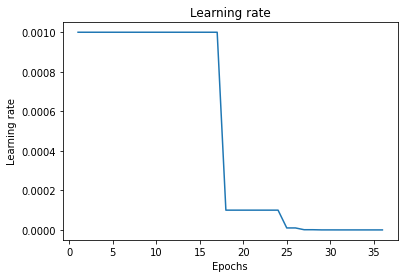

In [110]:
hist = history1.history
def plot_lr(history):
    learning_rate = history1.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()
    
plot_lr(history1)


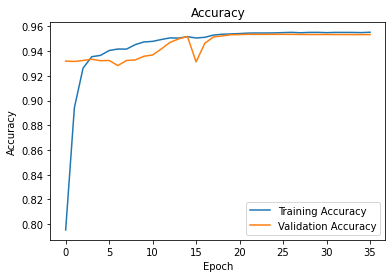

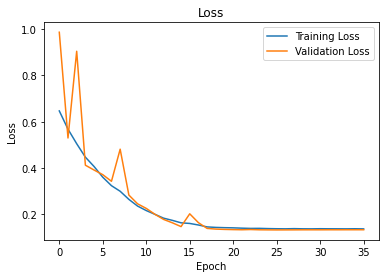

In [111]:
import matplotlib.pyplot as plt
hist = history1.history

#Accuracy Curve
plt.figure()
plt.plot(hist['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.figure(1)
plt.plot(hist['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"], loc ="lower right")


#Loss Curve
plt.figure()
plt.plot(hist['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(hist['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"], loc ="upper right")
plt.show()

## Validation & Loss Curves

In [58]:
# dict_df = pd.read_csv("history_v2.csv")
# #hist = dict(dict_df.values)
# histd = dict_df.to_dict('dict')
# del histd['Unnamed: 0']
# print(hist)

# #Importing Saved History Dictionary
# import csv


# reader = csv.reader(open('history_v1.csv'))
# hist = {}
# for row in reader:
#     key = row[0]
#     if key in hist:
#         # implement your duplicate row handling here
#         pass
#     hist[key] = row[1:]
# print(hist)


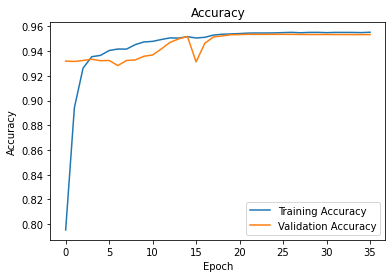

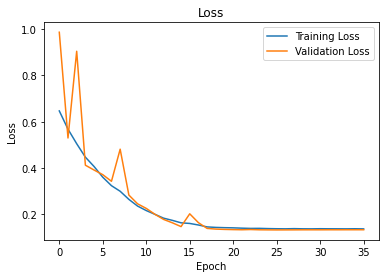

In [112]:
import matplotlib.pyplot as plt
hist = history1.history

#Accuracy Curve
plt.figure()
plt.plot(hist['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.figure(1)
plt.plot(hist['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training Accuracy","Validation Accuracy"], loc ="lower right")


#Loss Curve
plt.figure()
plt.plot(hist['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(hist['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training Loss", "Validation Loss"], loc ="upper right")
plt.show()

In [22]:
# import matplotlib.pyplot as plt
# hist = history1.history

# #Accuracy Curve
# plt.figure()
# plt.plot(hist['accuracy'])
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.figure(1)
# plt.plot(hist['val_accuracy'])
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(["Model Accuracy","Validation Accuracy"], loc ="lower right")


# #Loss Curve
# plt.figure()
# plt.plot(hist['loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.figure(2)
# plt.plot(hist['val_loss'])
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(["Model Loss", "Validation Loss"], loc ="lower left")
# plt.show()


In [23]:
# #Saving PLots
# plt.savefig('Learning Curves (F007_a changed).jpg')

## Test Images Predictions

# ---------------------------------------------------

In [113]:
#Loading Model
from keras.models import load_model
#model = unet()
# new_model = load_model('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unetfocal_aug.h5',custom_objects={'jacard_coef_loss':jacard_coef_loss, 
#                                                                                                         'jacard_coef': jacard_coef, 'f1_m':f1_m, 'precision_m':precision_m, 
#                                                                                                         'recall_m':recall_m, 'binary_focal_loss':binary_focal_loss, 'dice_coef':dice_coef})
#model.load_weights('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unetfocal_aug.h5') 

new_model = load_model('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unet_trial.h5',custom_objects={'jacard_coef_loss':jacard_coef_loss, 
                                                                                                         'jacard_coef': jacard_coef, 'f1_m':f1_m, 'precision_m':precision_m, 
                                                                                                         'recall_m':recall_m, 'dice_coef':dice_coef, 'binary_ce':binary_ce})
#model.load_weights('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unetfocal_aug.h5') 

## OLD

In [61]:
# from keras.models import load_model
# model = unet()
# model.load_weights('/home/keerthanaprasad/RajithaKV/Data_256_Unet/unetIOUv1_1.h5') 

# preds_test = model.predict(X_test, verbose=1)
# #Thresholding
# preds_test_t = (preds_test > 0.3).astype(np.uint8)

In [86]:
preds_test = new_model.predict(X_test, verbose=1)
#Thresholding
preds_test_t = (preds_test > 0.5).astype(np.uint8)

10/10 [==============================] - 3s 293ms/step


In [63]:
#preds_test[0]

In [64]:
preds_test_t.shape

(303, 256, 256, 1)

In [148]:
plt.imshow(preds_test_t[i,:,:,0])

NameError: name 'i' is not defined

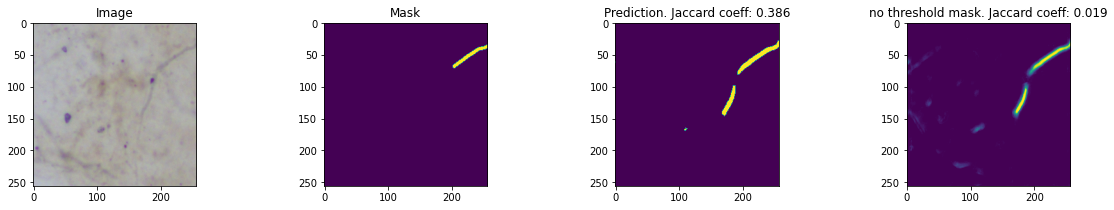

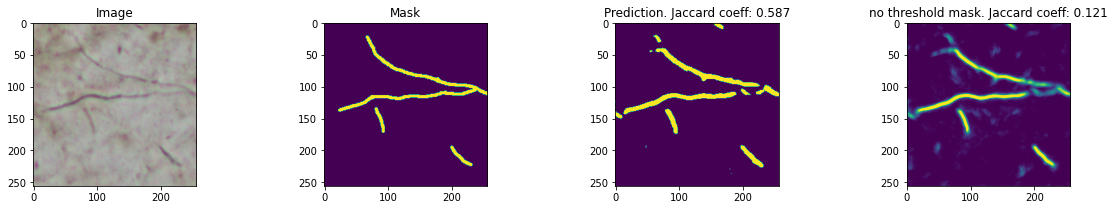

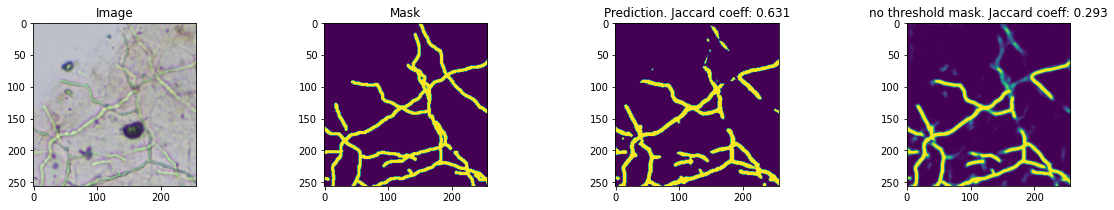

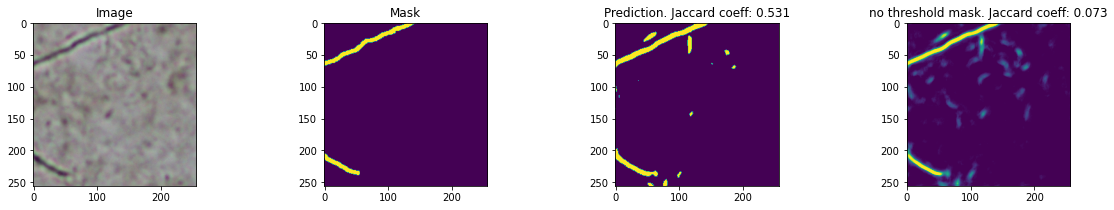

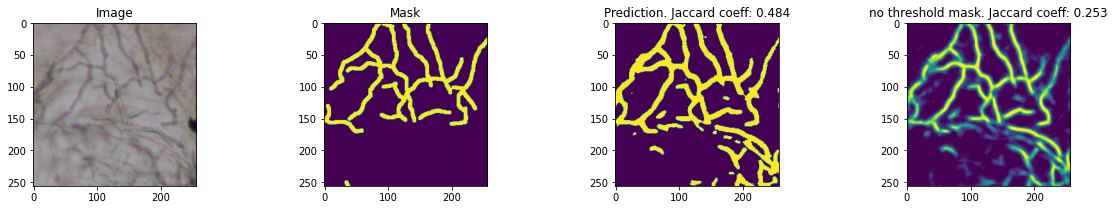

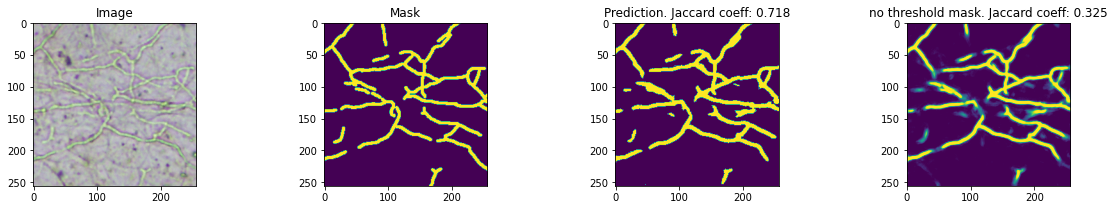

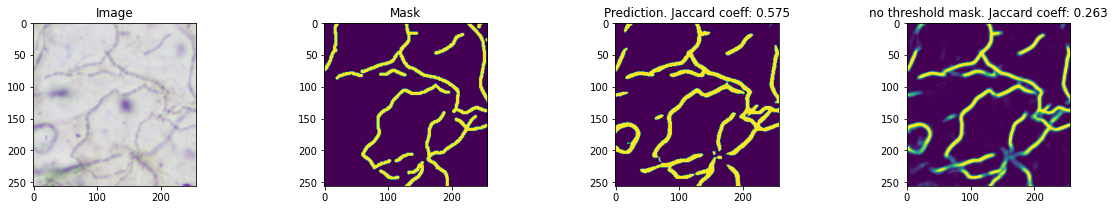

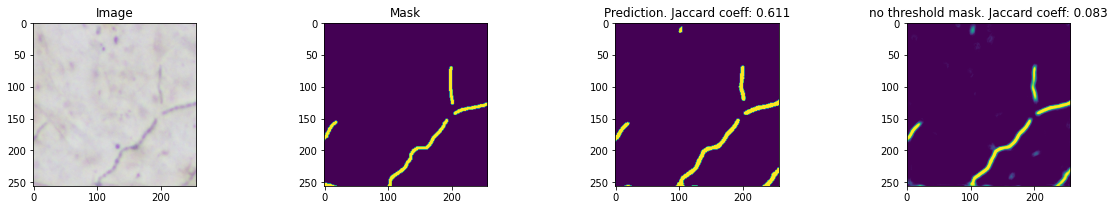

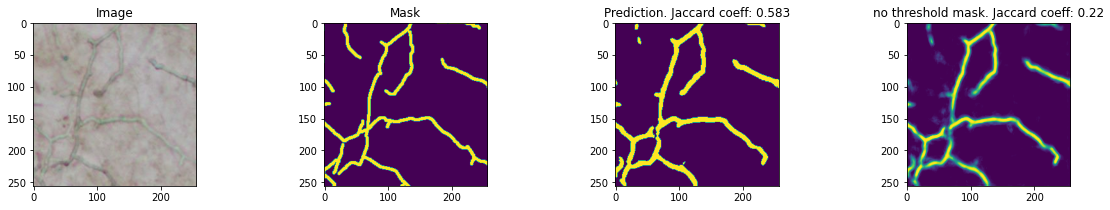

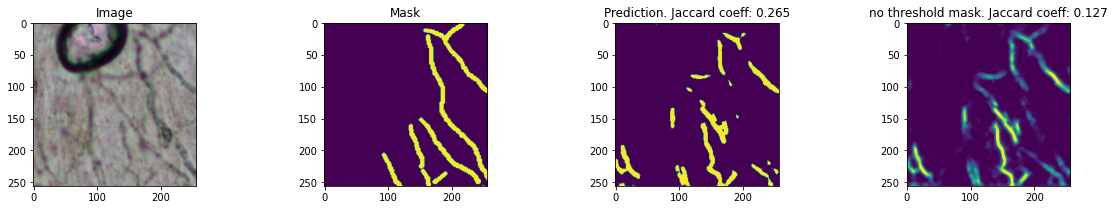

In [87]:
preds_test_t = preds_test_t.astype(float)
preds_test=preds_test.astype(float)
for i in range(10):
    # print(i)
    plt.figure( figsize=(20,3) )
    plt.subplot(141)
    plt.imshow(X_test[i])
    plt.title('Image')
    plt.subplot(142)
    plt.imshow(Y_test[i])
    plt.title('Mask')
    plt.subplot(143)
    plt.imshow(preds_test_t[i,:,:,0])
    #cv2.imwrite('/content/drive/MyDrive/Dummy/Prediction images',preds_test_t[i,:,:,0])
    plt.title('Prediction. Jaccard coeff: ' + str(np.around(jacard_coef(Y_test[i], preds_test_t[i,:,:,0]), 3)))
    plt.subplot(144)
    plt.imshow(preds_test[i,:,:,0])
    plt.title('no threshold mask. Jaccard coeff: ' + str(np.around(jacard_coef(Y_test[i], preds_test[i,:,:,0]), 3)))
    plt.show()

In [88]:
print("Shapes :\n======\nY_test = {}\npreds_test_t = {}"
      .format(Y_test.shape, preds_test_t.shape))

Shapes :
Y_test = (303, 256, 256)
preds_test_t = (303, 256, 256, 1)


In [89]:
# evaluate model
mtrics = new_model.evaluate(X_test, Y_test)
print("Accuracy of Jacard Model is = ", (mtrics[6]*100), "%")
print("Jacard Score of Jacard Model is = ", (mtrics[1]*100), "%")
print("F1 Score of Jacard Model is = ", (mtrics[2]*100), "%")
print("Precision of Jacard Model is = ", (mtrics[3]*100), "%")
print("Recall of Jacard Model is = ", (mtrics[4]*100), "%")
print("Dice Score of Jacard Model is = ", (mtrics[5]*100), "%")
print("MIOU of Jacard Model is = ", (mtrics[7]*100), "%")

10/10 [==============================] - 3s 263ms/step - loss: 0.3531 - jacard_coef: 0.1437 - f1_m: 0.6647 - precision_m: 0.5998 - recall_m: 0.7475 - dice_coef: 0.3869 - accuracy: 0.9512
Accuracy of Jacard Model is =  95.11836767196655 %
Jacard Score of Jacard Model is =  14.37113881111145 %
F1 Score of Jacard Model is =  66.47470593452454 %
Precision of Jacard Model is =  59.980642795562744 %
Recall of Jacard Model is =  74.75193738937378 %
Dice Score of Jacard Model is =  38.689976930618286 %


IndexError: list index out of range

In [34]:
#print(model.metrics_names)